In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load the data, which is from VisIt, extracted from AMRVAC output *.vtu file
x, y, b1, b2, b3 = np.loadtxt('/Users/yao/Documents/Data/AMRVAC/test1/visit_b1_b2_b3_0010.xyz',
                        unpack=True,skiprows=2,usecols=[1,2,4,5,6])

In [3]:
# this is the function to reshape the data into a 2D grid
# due to the AMR, the data needs to be filled with NaN to make a regular grid
# which is not a good idea, but it is the only working method for now

def grid_data(x, y, data, Nx, Ny):
    xi = np.searchsorted(np.unique(x), x)
    yj = np.searchsorted(np.unique(y), y)
    flat_idx = xi * Ny + yj
    order = np.argsort(flat_idx)
    flat_idx = flat_idx[order]
    uniq_flat, start_idx, counts = np.unique(flat_idx, return_index=True, return_counts=True)
    data_sorted = data[order]
    data_sum = np.add.reduceat(data_sorted, start_idx)
    data_mean = data_sum / counts
    data_grid = np.full((Nx, Ny), np.nan)
    ii = uniq_flat // Ny
    jj = uniq_flat % Ny
    data_grid[ii, jj] = data_mean
    return data_grid

In [4]:
# we get the grid size from the unique x and y values, and then reshape the data accordingly
# and it is the XXX_grid 2D arrays that we have to use

xu = np.unique(x)
yu = np.unique(y)
Nx, Ny = xu.size, yu.size

x_grid  = grid_data(x, y, x,  Nx, Ny)
y_grid  = grid_data(x, y, y,  Nx, Ny)
b1_grid = grid_data(x, y, b1, Nx, Ny)
b2_grid = grid_data(x, y, b2, Nx, Ny)
b3_grid = grid_data(x, y, b3, Nx, Ny)

In [5]:
# prepare for plotting

xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)

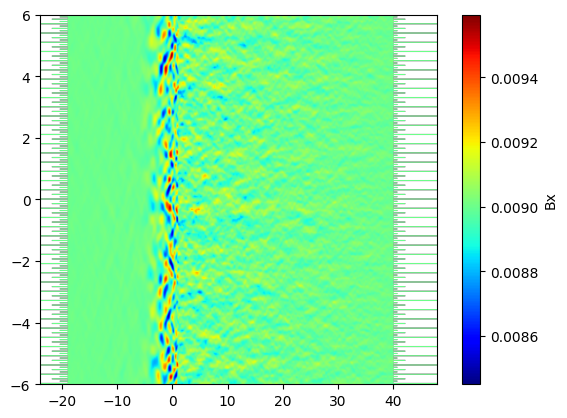

In [6]:
# have a quick visual check
# note the NaN values on the boundary of AMR blocks
# we will have to mask them out when doing FFT of the data (of the magnetic fields)
# for now, we just roughly take a range of [-10, 30] along x, which we see clearly that there is no NaN

plt.imshow(b1_grid.T, 
           origin='lower', 
           extent=(xmin, xmax, ymin, ymax), 
           cmap='jet',
           aspect='auto')
plt.colorbar(label='Bx')

In [7]:
# Converting simulation units to physical units

v0 = 1e-4            # in the code unit from the par file
n0 = 0.002

mpCGS=1.67e-24                          # g
vA=v0*3.0e10                            # cm/s
ni=n0                                   # cm^-3
B0=vA*np.sqrt(4.0*np.pi*ni*mpCGS)*1.0e6 # uG
print('Field strength of the ordered field = %.2e uG' % B0)

Field strength of the ordered field = 6.15e-01 uG


In [8]:
# now we do the mask
# even just 1 number

mask = (xu >= 10) & (xu <= 20) # manually set the region according to the above plot
b1_new = b1_grid[mask,:]
b2_new = b2_grid[mask,:]
b3_new = b3_grid[mask,:]
x_new = x_grid[mask,:]
y_new = y_grid[mask,:]

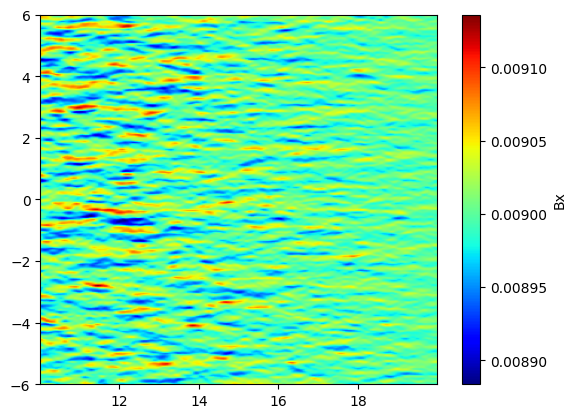

In [9]:
# It is necessary to recheck the array after the masking
# as different mask region gives different result, i.e., use [10,30] and you will see

# update the plotting region after the mask
# this is also important as we will use the updated ones for FFT

xmin = np.min(x_new)
xmax = np.max(x_new)
ymin = np.min(y_new)
ymax = np.max(y_new)

plt.imshow(b1_new.T, 
           origin='lower', 
           extent=(xmin, xmax, ymin, ymax), 
           cmap='jet',
           aspect='auto')
plt.colorbar(label='Bx')

In [10]:
# now, the Nx and Ny also needs to be updated

Nx_new, Ny_new = x_new.shape[0], x_new.shape[1]
print(Nx_new)
print(Ny_new)

267
321


In [11]:
kx=(np.fft.fftshift(np.fft.fftfreq(Nx_new,(xmax-xmin)/Nx_new)))*2.0*np.pi
ky=(np.fft.fftshift(np.fft.fftfreq(Ny_new,(ymax-ymin)/Ny_new)))*2.0*np.pi
kxmin=np.min(kx)
kxmax=np.max(kx)
kymin=np.min(ky)
kymax=np.max(ky)

print(kxmin, kxmax, kymin, kymax)

-83.77580913487425 83.77580913487425 -83.77580409572784 83.77580409572784


In [15]:
# Apply 2D FFT
b1_fft=np.fft.fft2(b1_new)
b2_fft=np.fft.fft2(b2_new)
b3_fft=np.fft.fft2(b3_new)

b_perp = b2_new**2 + b3_new**2

b_perp_fft=np.fft.fft2(b_perp)

print(b3_fft.shape)
# print_nan(b3_fft)

(267, 321)


In [14]:
# check if there's NaN (and how many) in the FFTed array
# you want to see a lot of False and 0

def print_nan(a):
    # Boolean mask of NaN positions
    mask = np.isnan(a)
    print(mask)

    # Check if there is at least one NaN
    print(np.any(mask))

    # Count how many NaNs
    print('There is ', np.sum(mask), 'of NaNs out of an array of size:', a.size)

    # Get indices of NaNs
    print(np.where(mask))
    return 0

print_nan(b3_fft)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
False
There is  0 of NaNs out of an array of size: 85707
(array([], dtype=int64), array([], dtype=int64))


0

In [16]:
# Shift the zero frequency component to the center
b1_fft_shifted=np.fft.fftshift(b1_fft)
b2_fft_shifted=np.fft.fftshift(b2_fft)
b3_fft_shifted=np.fft.fftshift(b3_fft)
b_perp_fft_shifted=np.fft.fftshift(b_perp_fft)

# Compute the magnitude 
P_11_mag=np.abs(b1_fft_shifted)**2
P_22_mag=np.abs(b2_fft_shifted)**2
P_33_mag=np.abs(b3_fft_shifted)**2
P_mag = np.abs(b_perp_fft_shifted)**2

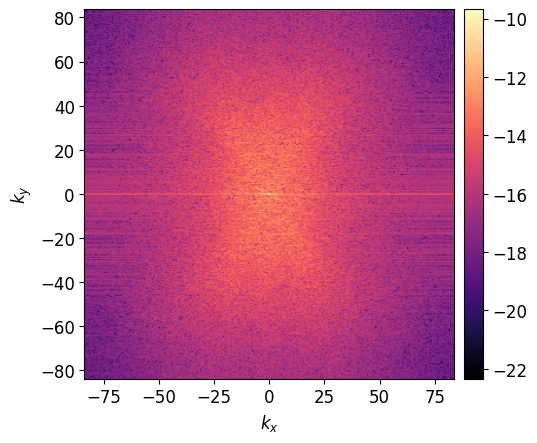

In [17]:
# have a visual check of the magnitude of the FFT-shifted array

fs = 12 # fontsize

fig, ax = plt.subplots()

im = ax.imshow(np.log10(P_mag).T,
               extent=[kxmin, kxmax, kymin, kymax],
               origin='lower',
            #    vmin=0,
            #    vmax=0.01,
               cmap='magma')

# ax.set_title(r'$P_{11}(k_x,k_y)$', fontsize=fs)
ax.set_xlabel(r'$k_x$', fontsize=fs)
ax.set_ylabel(r'$k_y$', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(im, cax=cax).ax.tick_params(labelsize=fs)

#### now we need to have the proper way to get the 

$S_{\perp}(k)=\frac{\left|\delta \hat{B}_{\perp}^2(k)\right|}{B_0^2}$

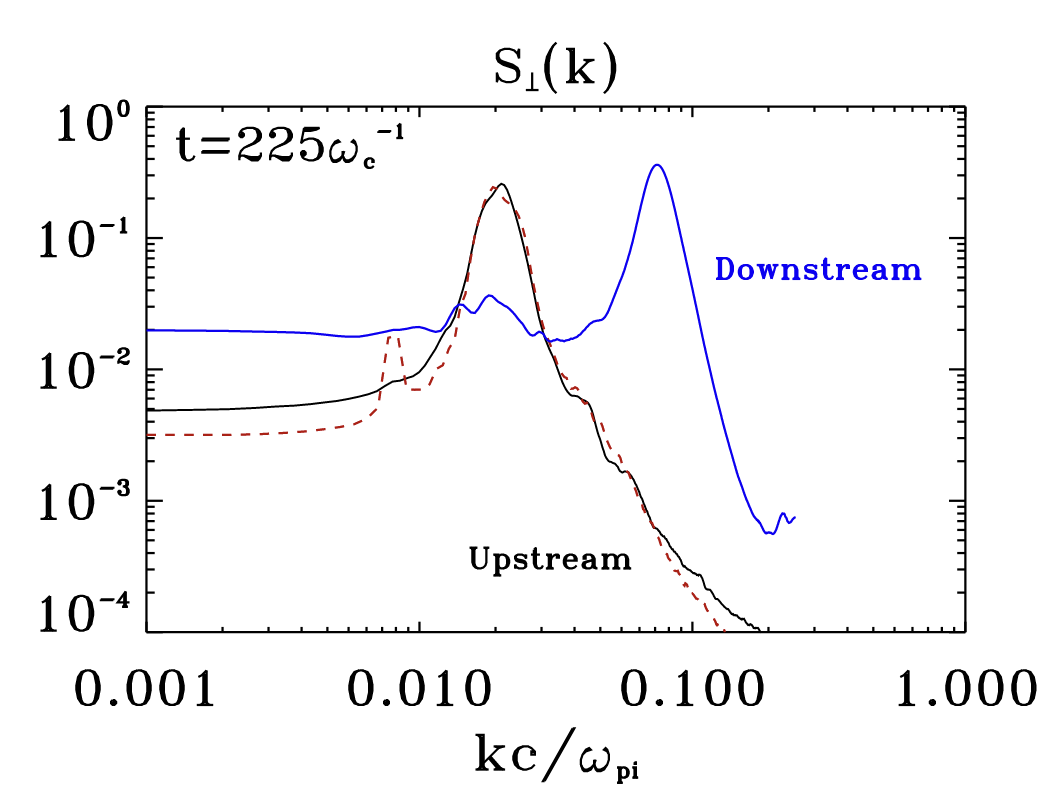

#### note that here we need $k_y$

#### Also, there is a need to fix the units, from the code ones to the $\omega_{pi}/c$, like in the paper.

#### Then, the particle data to be dealt with

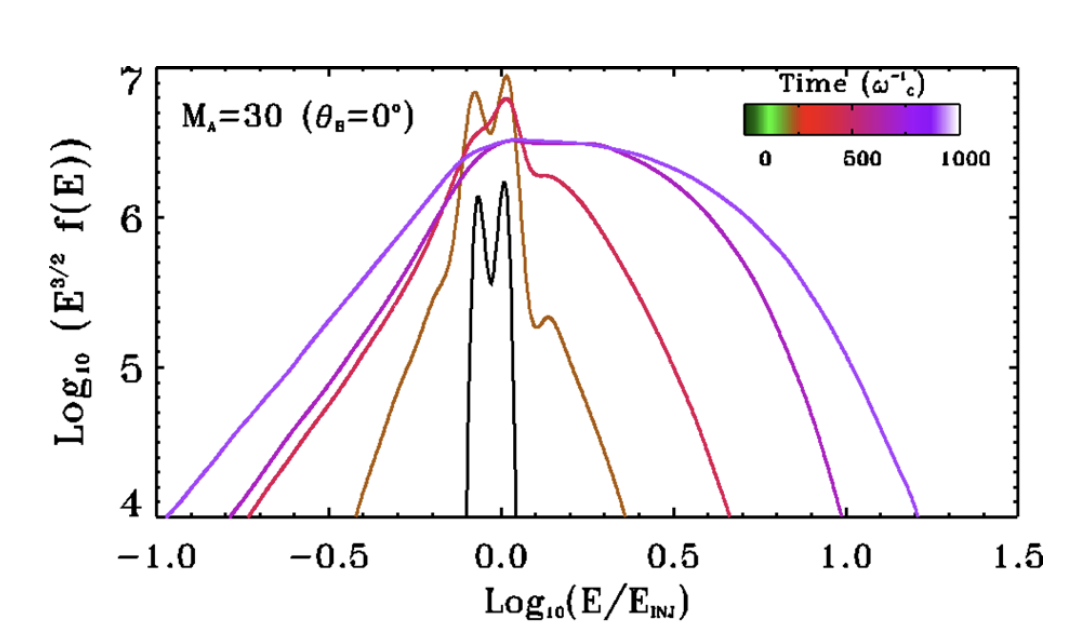